In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import os
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,LabelEncoder,MaxAbsScaler,RobustScaler
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE,ADASYN,SMOTE,SVMSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from math import ceil
from numpy.random import RandomState
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest,f_classif,mutual_info_classif
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

### Functions

In [2]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation="vertical")
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'),labelspacing =1)
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation="vertical")
    plt.show()
    

In [3]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    

In [4]:
def micro_f1_score(y_train, pred_train , y_val, pred_val):
        print('_____________________________________')
        print('                                                     TRAIN                                                 ')
        print('-----------------------------------------------------------------------------------------------------------')
        print(f1_score(y_train, pred_train, average='micro'))


        print('_____________________________________')
        print('                                                VALIDATION                                                 ')
        print('-----------------------------------------------------------------------------------------------------------')
        print(f1_score(y_val, pred_val, average='micro'))
        return f1_score(y_val, pred_val, average='micro')

In [5]:
def best_scale(model,X_train,y_train,X_test,y_test):
    standard=StandardScaler().fit(X_train).transform(X_train)
    standardTest=StandardScaler().fit(X_test).transform(X_test)

    minMax=MinMaxScaler().fit(X_train).transform(X_train)
    minMaxTest=MinMaxScaler().fit(X_test).transform(X_test)

    maxAbs=MaxAbsScaler().fit(X_train).transform(X_train)
    maxAbsTest=MaxAbsScaler().fit(X_test).transform(X_test)
        
    robust=RobustScaler().fit(X_train).transform(X_train)
    robustTest=RobustScaler().fit(X_test).transform(X_test)

    sclares=[standard,minMax,maxAbs,robust,X_train]
    sclaresTest=[standardTest,minMaxTest,maxAbsTest,robustTest,X_test]
    
    f_score=[]
    
    for i in range(len(sclares)):
        model.fit(sclares[i],y_train)
        y_pred=model.predict(sclaresTest[i])
        f_score.append(f1_score(y_pred,y_test,average="micro"))
        

    return pd.DataFrame(f_score,index=["Standard","MinMax","MaxAbs","Robust","No Scaler"], columns=["F1 Score"])
    

### Reading the Data

In [7]:
original = pd.read_excel("../train.xlsx")
original.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [8]:
df=original.copy()

In [9]:
df.replace("?", np.nan, inplace=True)
df.isna().sum()

CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [10]:
df.isna().sum()/len(df)*100

CITIZEN_ID                0.000000
Name                      0.000000
Birthday                  0.000000
Native Continent          0.000000
Marital Status            0.000000
Lives with                0.000000
Base Area                 1.763393
Education Level           0.000000
Years of Education        0.000000
Employment Sector         5.642857
Role                      5.674107
Working Hours per week    0.000000
Money Received            0.000000
Ticket Price              0.000000
Income                    0.000000
dtype: float64

In [11]:
df[["Gender","Name"]]=df["Name"].str.split(" ", n=1,expand=True)
df["Gender"].replace(["Mr."],"M",inplace=True)
df["Gender"].replace(["Miss","Mrs."],"F",inplace=True)

In [12]:
df[["Mouth","Year"]]=df['Birthday'].str.split(",",expand=True)
df["Year"]=df["Year"].astype(int)
df["Age"] = 2046 - df["Year"]

In [13]:
df.set_index("CITIZEN_ID",inplace=True)

In [14]:
df.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

### New variables

In [15]:
#df["Working Hours per week/age"]=df["Working Hours per week"]/df["Age"]*100
#df["Years of Education/age"]=df["Years of Education"]/df["Age"]*100
#df["Working Hours per week/Years of Education"]=df["Working Hours per week"]/df["Years of Education"]

In [16]:
categorical = df.select_dtypes(include="object").columns.to_list()
numerical = df.columns.drop(categorical).drop("Income").to_list()

### Visualize

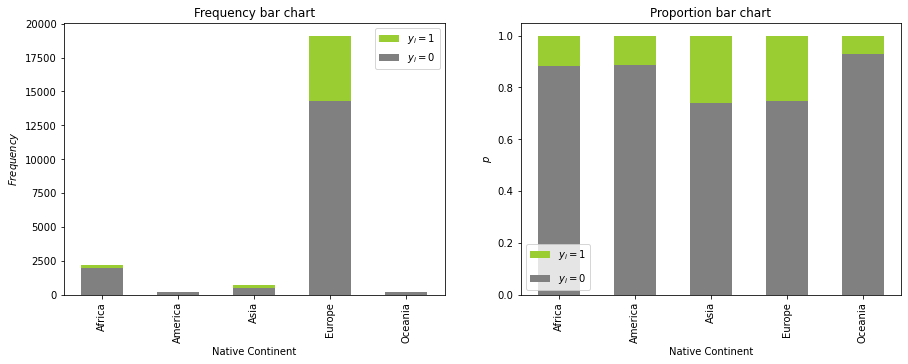

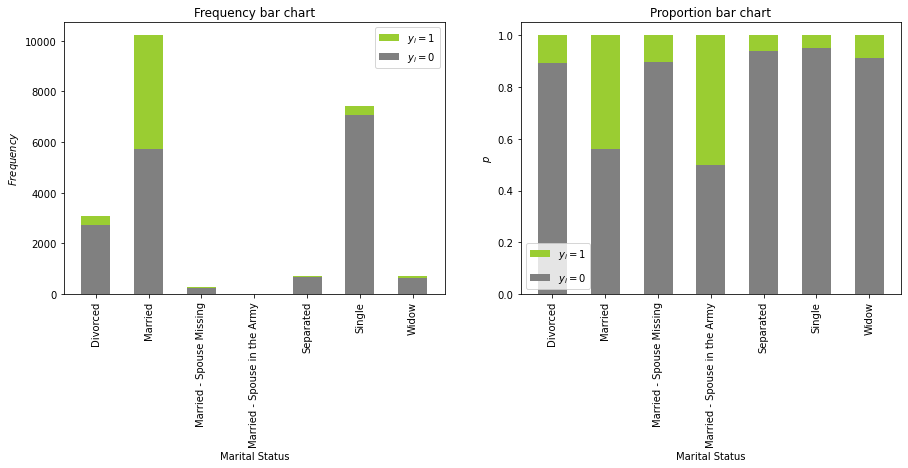

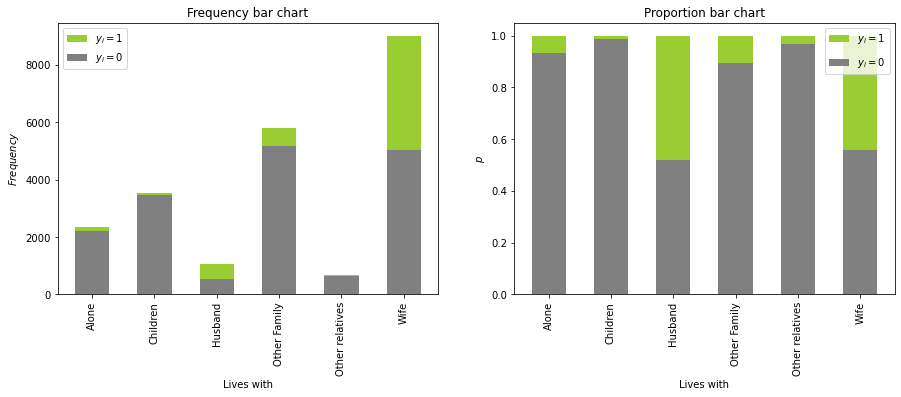

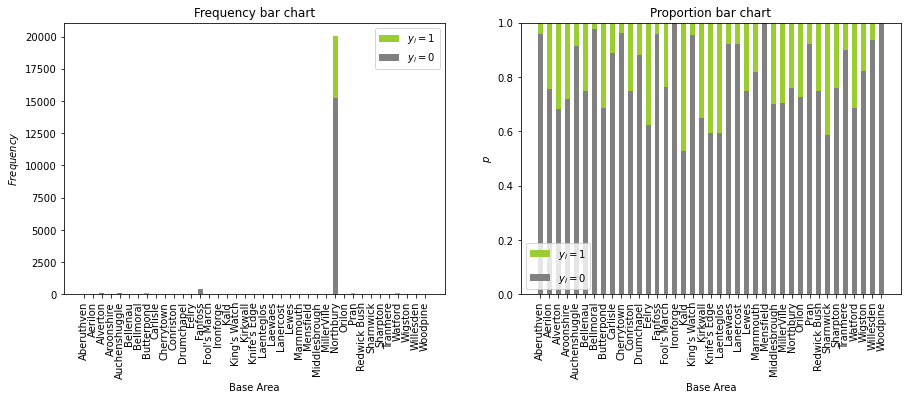

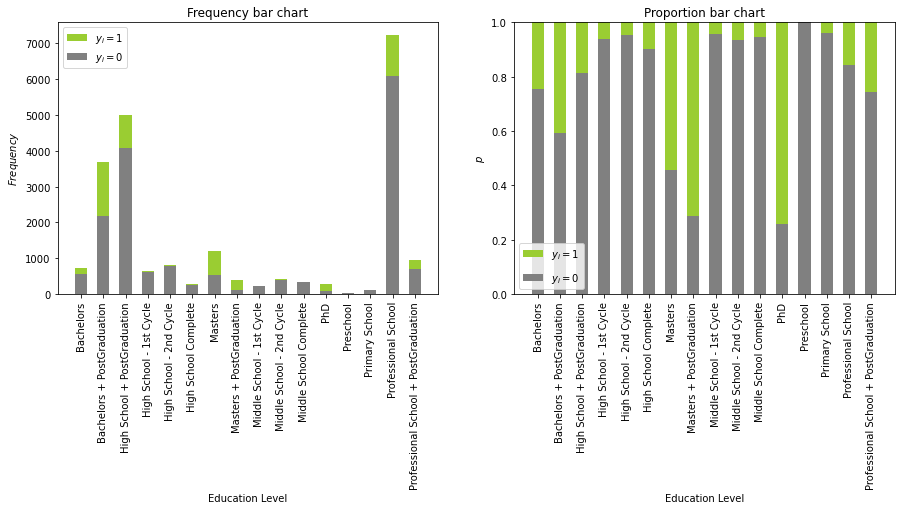

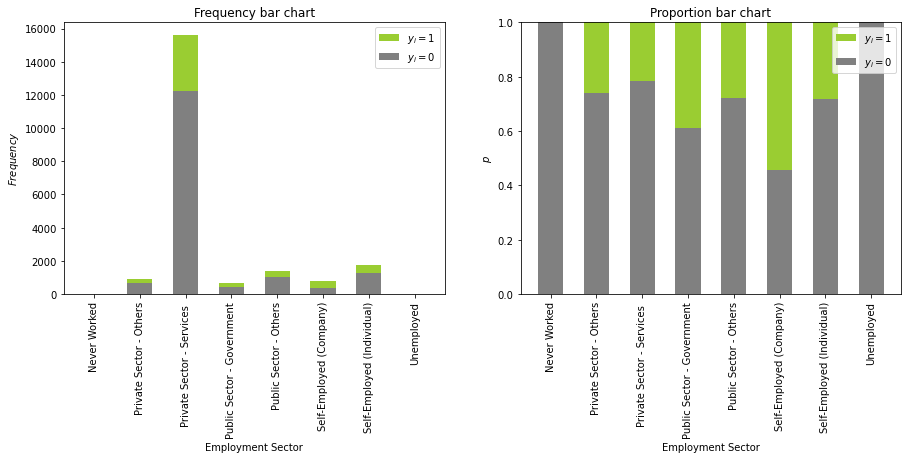

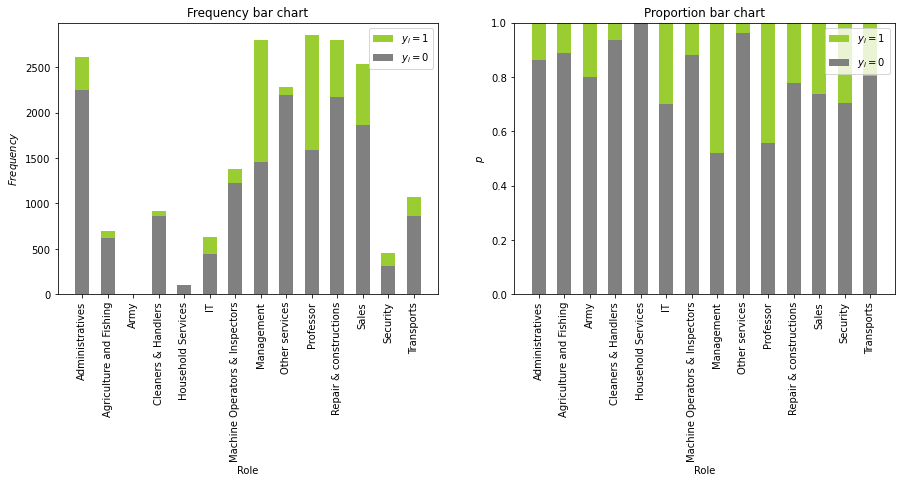

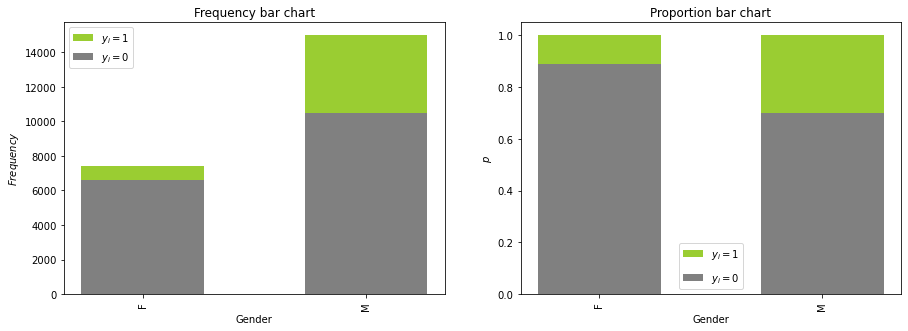

In [17]:
for i in categorical:   
    bar_charts_categorical(df, i, "Income")

In [18]:
df["Marital Status"].replace(["Married - Spouse in the Army" ],"Married",inplace=True)
df["Marital Status"].replace(["Married - Spouse Missing" ,"Widow","Divorced"],"Other",inplace=True)

In [19]:
df["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
df["Lives with"].replace(["Other relatives","Children"],"Other",inplace=True)

In [20]:
#tem demasiadas categorias
df.drop(["Base Area"],axis=1,inplace=True)
categorical.remove("Base Area")

In [21]:
df["Education Level"].replace(["High School - 2nd Cycle","High School - 1st Cycle","Middle School Complete","Primary School","Preschool","High School Complete","High School - 1st Cycle","High School - 2nd Cycle","Professional School","Middle School - 1st Cycle","Middle School - 2nd Cycle"],"No college degree",inplace=True)
df["Education Level"].replace(["High School + PostGraduation","Bachelors","Professional School + PostGraduation"],"1 Degree",inplace=True)
df["Education Level"].replace(["Bachelors + PostGraduation","Masters"],"2 Degrees",inplace=True)
df["Education Level"].replace(["Masters + PostGraduation","PhD"],"3 Degrees",inplace=True)

In [22]:
df["Employment Sector"].replace(["Private Sector - Services ","Private Sector - Others"],"Private Sector",inplace=True)
df["Employment Sector"].replace(["Public Sector - Others","Public Sector - Government"],"Public Sector",inplace=True)
df["Employment Sector"].replace(["Unemployed","Never Worked"],"Other",inplace=True)

In [23]:
df["Role"].replace(["Cleaners & Handlers","Machine Operators & Inspectors","Administratives","Agriculture and Fishing","Household Services"],"Other services",inplace=True)

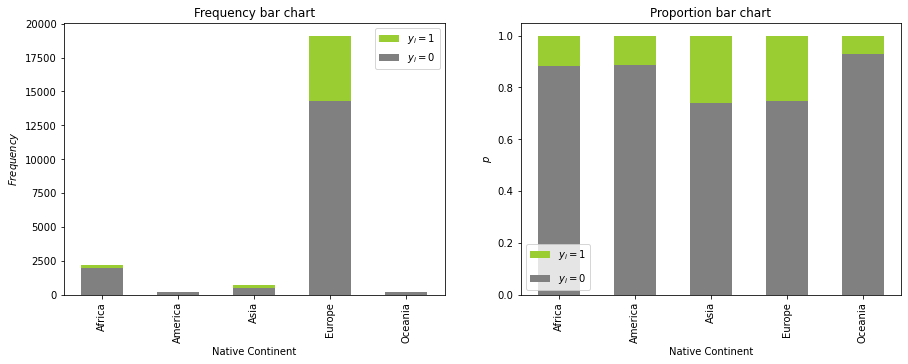

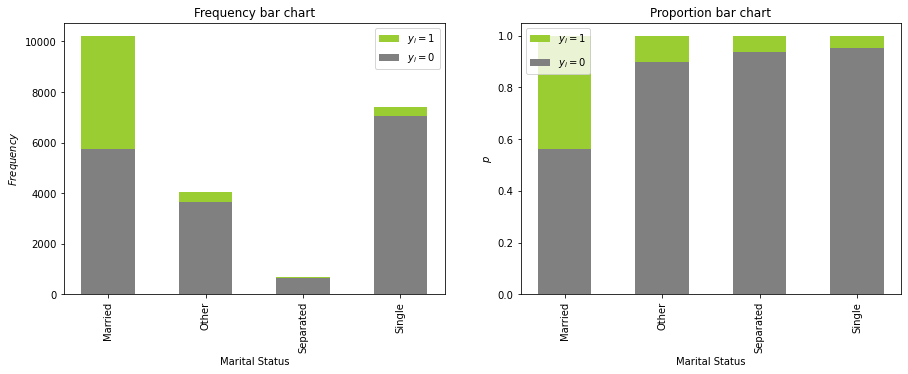

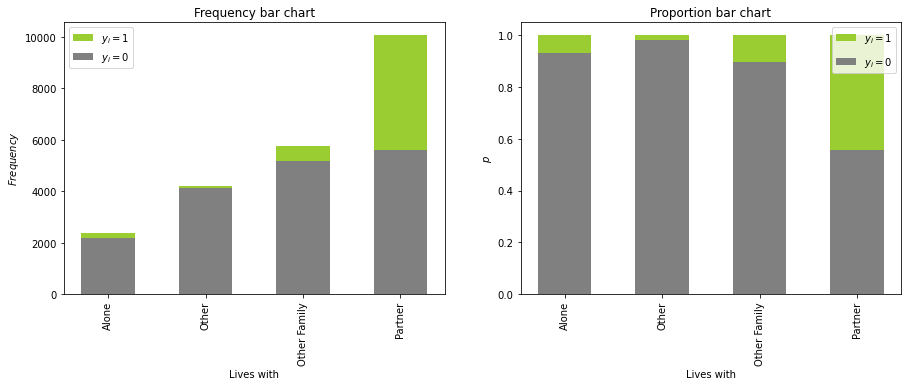

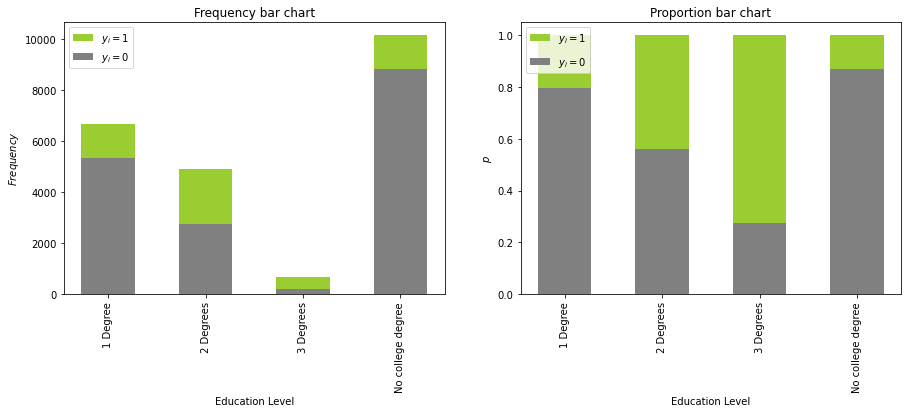

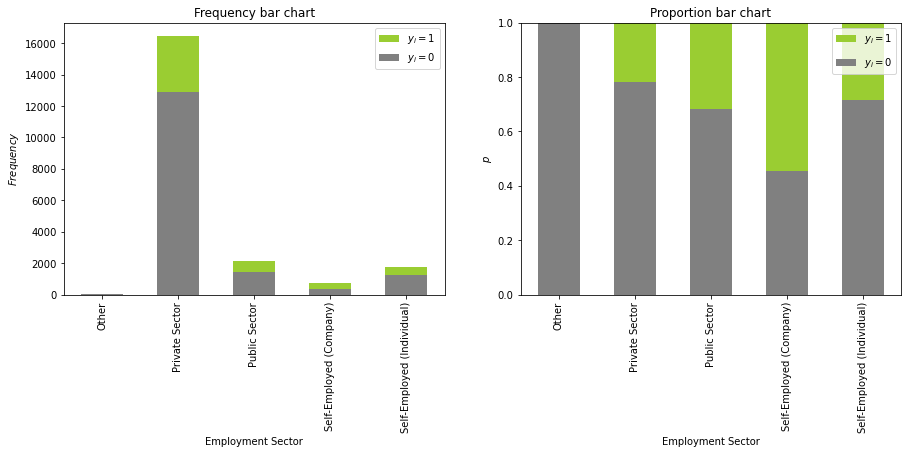

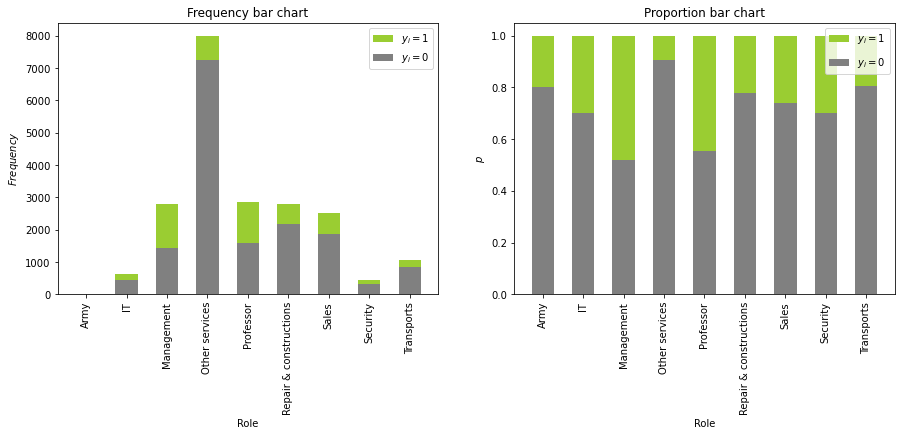

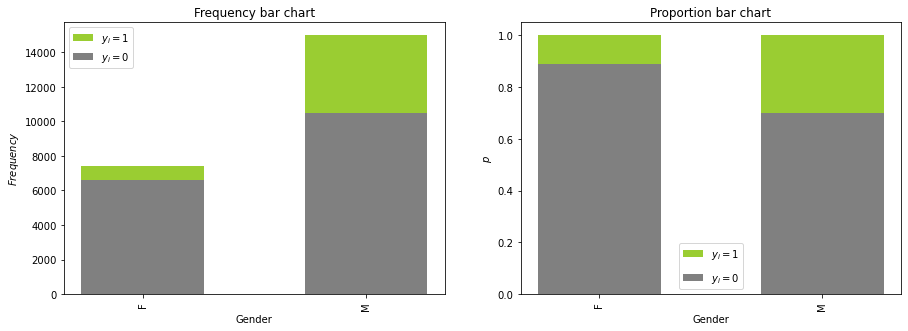

In [24]:
for i in categorical:   
    bar_charts_categorical(df, i, "Income")

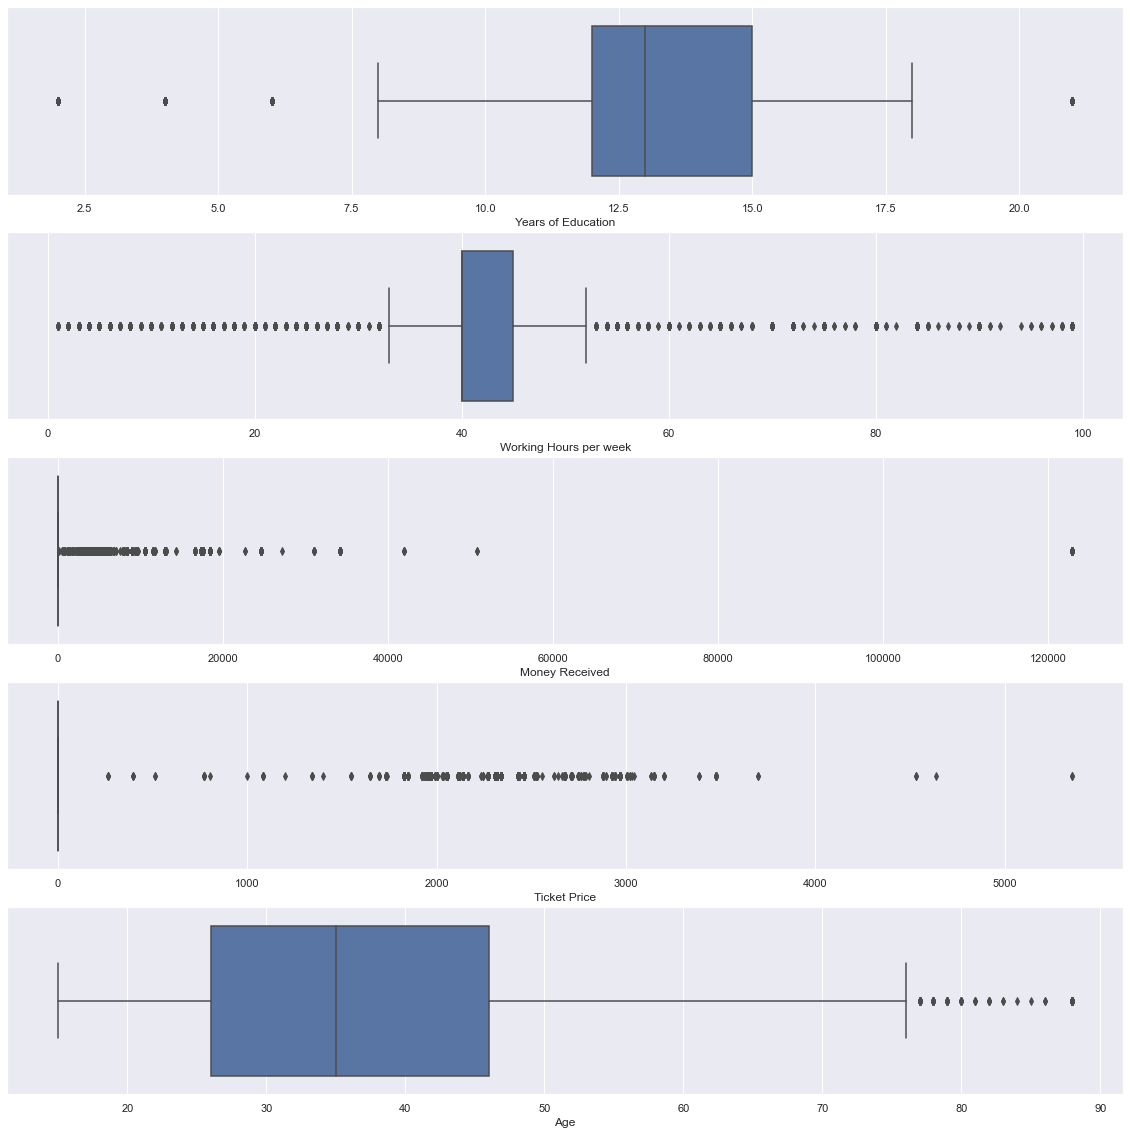

In [25]:
sns.set()
fig, axes = plt.subplots(len(numerical), ceil(len(numerical) / len(numerical)), figsize=(20, 20))
for ax, feat in zip(axes.flatten(), numerical):
    sns.boxplot(x=df[feat], ax=ax) 
plt.show()

### Fill Missing Values

In [26]:
modes = df[categorical].mode().loc[0]
df.fillna(modes,inplace=True)

### Removing Outliers

In [27]:
filters = (
    (df["Working Hours per week"]>7)
    & 
    (df["Years of Education"]<20)
    &
    (df["Ticket Price"]<4000)
    &
    (df["Money Received"]<120000))

df1=df[filters]
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / original.shape[0], 4))
#df=df1.copy()

Percentage of data kept after removing outliers: 0.9735


### Separating X and Y

In [28]:
X=df.drop(["Income","Native Continent"],axis=1)
y=df.loc[:,"Income"]
categorical=X.select_dtypes(include="object").columns.to_list()

### One Hot Encoder

In [29]:
df_ohc = X.copy()
categorical=X.select_dtypes(include="object").columns.to_list()
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
X=df_ohc.copy()
X.head()

,Marital Status_Married,Marital Status_Other,Marital Status_Separated,Marital Status_Single,Lives with_Alone,Lives with_Other,Lives with_Other Family,Lives with_Partner,Education Level_1 Degree,Education Level_2 Degrees,...,Role_Sales,Role_Security,Role_Transports,Gender_F,Gender_M,Years of Education,Working Hours per week,Money Received,Ticket Price,Age
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,13,40,0,2273,43
12487,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,12,40,0,0,40
12488,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,12,46,0,2321,37
12489,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,11,37,5395,0,61
12490,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,21,45,0,0,31


In [30]:
X.drop(["Marital Status_Separated","Lives with_Other","Education Level_3 Degrees","Employment Sector_Other","Role_Army","Gender_F"],axis=1,inplace=True)

## Data Splitting

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

### Model

In [32]:
gb = GradientBoostingClassifier(n_estimators=100,max_features=15,random_state=100,max_depth=16,min_samples_leaf=8) 
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=16, max_features=15, min_samples_leaf=8,
                           random_state=100)

In [33]:
best_scale(gb,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.839732
MinMax,0.858036
MaxAbs,0.858259
Robust,0.859375
No Scaler,0.858482


### Feature Selection

In [34]:
importances = gb.feature_importances_
indices = np.argsort(importances)

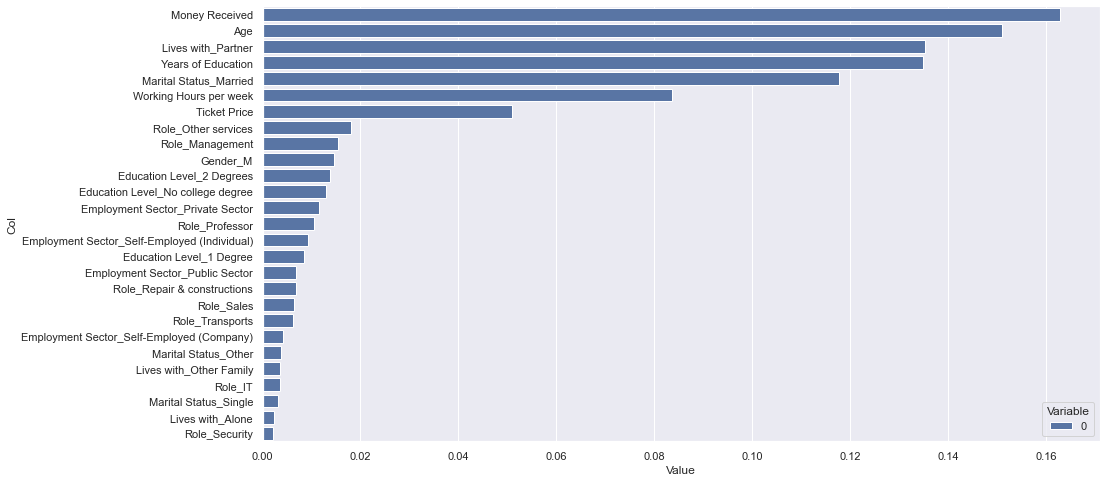

In [35]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [36]:
X_gb=X.drop(["Marital Status_Single","Lives with_Alone","Role_Security"],axis=1)

In [37]:
feature_columns=X_gb.columns

## Data Split after feature selection

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_gb, y, train_size=0.8, random_state=42,stratify=y,shuffle=True) 

In [39]:
gb = GradientBoostingClassifier(n_estimators=100,max_features=15,random_state=70,max_depth=6,min_samples_leaf=10) 
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=6, max_features=15, min_samples_leaf=10,
                           random_state=70)

In [40]:
y_train_pred= gb.predict(X_train)
y_test_pred=gb.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     13671
           1       0.81      0.66      0.73      4249

    accuracy                           0.88     17920
   macro avg       0.86      0.81      0.83     17920
weighted avg       0.88      0.88      0.88     17920

[[13028   643]
 [ 1429  2820]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [41]:
gb_f1_test= micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.8843749999999999
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.8747767857142856


### Cross-Validation

In [42]:
cv_results = cross_validate(gb, X_train,y_train, cv=5, scoring=["f1_micro"])
gb_cross_f1=cv_results["test_f1_micro"].mean()
gb_cross_f1

0.8671875

In [64]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, gb.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, gb.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 17 

### Grid Search Cv

In [62]:
max_depth_range=[5,6,7] 
min_samples_leaf_range=[8,9,10,11]
max_features_range=[12,15,17]
n_estimators_range=[100,300,500]
random_state_range=[20,35,70]
param_grid=dict(max_depth=max_depth_range,min_samples_leaf=min_samples_leaf_range)
grid=GridSearchCV(estimator=gb,param_grid=param_grid, cv =5)

In [63]:
#grid.fit(X_train,y_train)
#grid.best_params_

## AdaBoost 

### Data Splitting

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

In [49]:
ada=AdaBoostClassifier()
ada.fit(X_train,y_train)

AdaBoostClassifier()

In [50]:
best_scale(ada,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.851339
MinMax,0.862500
MaxAbs,0.862500
Robust,0.861830
No Scaler,0.862500


### Feature Selection

In [51]:
importances = ada.feature_importances_
indices = np.argsort(importances)

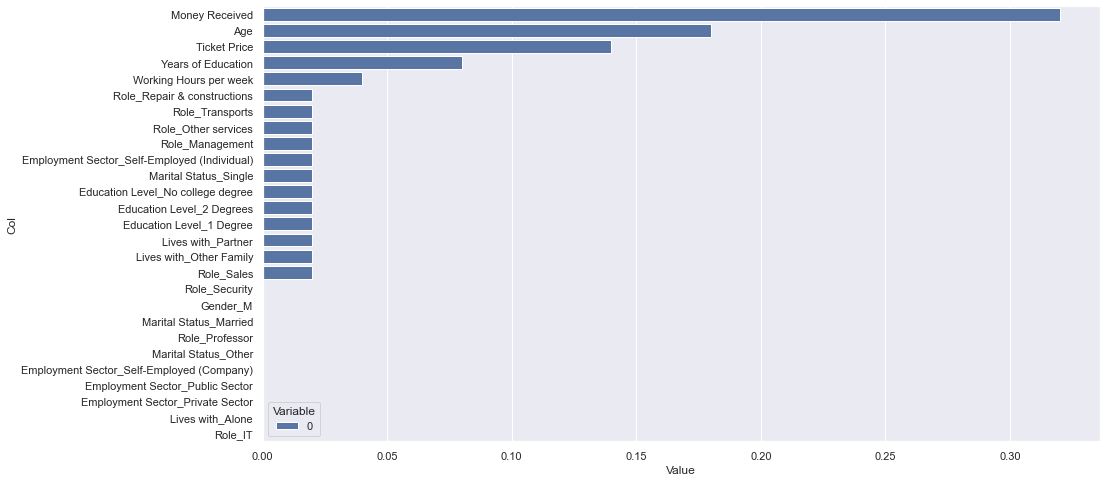

In [52]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [53]:
X_ada = X.drop(["Role_IT","Lives with_Alone","Employment Sector_Private Sector","Employment Sector_Self-Employed (Company)","Employment Sector_Private Sector","Marital Status_Other","Education Level_No college degree","Employment Sector_Public Sector","Role_Security","Role_Professor","Gender_M"],axis=1)

### Data Split after feature selection

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_ada, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    stratify=y)

In [55]:
ada=AdaBoostClassifier(n_estimators=100,algorithm="SAMME",random_state=70,learning_rate=0.01)
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01, n_estimators=100,
                   random_state=70)

In [56]:
y_train_pred= ada.predict(X_train)
y_test_pred=ada.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      1.00      0.87     13671
           1       0.00      0.00      0.00      4249

    accuracy                           0.76     17920
   macro avg       0.38      0.50      0.43     17920
weighted avg       0.58      0.76      0.66     17920

[[13671     0]
 [ 4249     0]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
ada_f1_test= micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.762890625
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.7629464285714285


In [58]:
cv_results = cross_validate(ada, X_train,y_train, cv=5, scoring=["f1_micro"])
ada_cross_f1=cv_results["test_f1_micro"].mean()
ada_cross_f1

0.7628906249999998

In [65]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ada.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ada.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

TypeError: roc_curve() missing 3 required positional arguments: 'X_test', 'y_train', and 'y_test'

## Random Forest

### Data Splitting

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

In [67]:
rf = RandomForestClassifier(class_weight={1:2},criterion="entropy",n_estimators=100,max_features=16,random_state=100,n_jobs=-1,max_depth=16,min_samples_leaf=8)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={1: 2}, criterion='entropy', max_depth=16,
                       max_features=16, min_samples_leaf=8, n_jobs=-1,
                       random_state=100)

In [68]:
best_scale(rf,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.841741
MinMax,0.850446
MaxAbs,0.850893
Robust,0.849107
No Scaler,0.850893


### Feature Selection

In [69]:
importances = rf.feature_importances_
indices = np.argsort(importances)

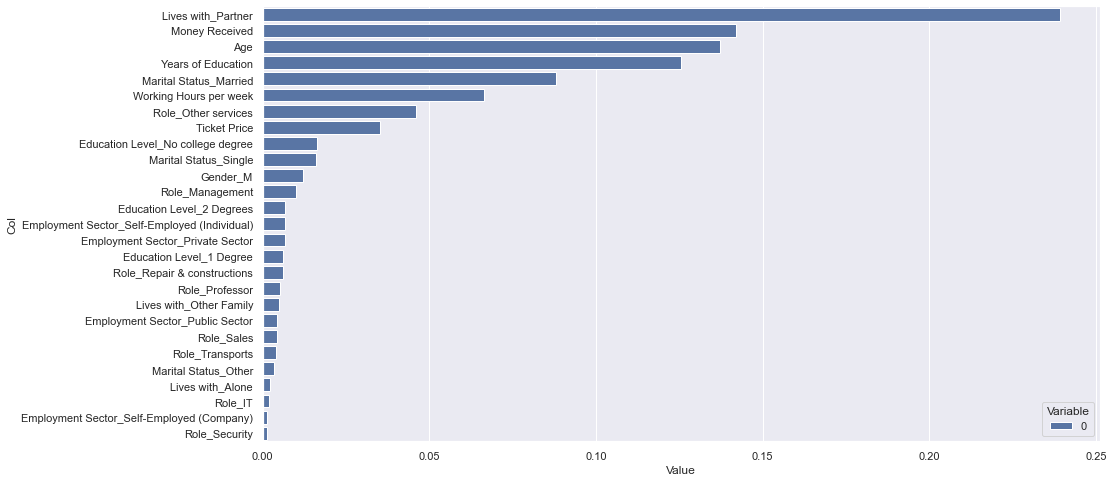

In [70]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [71]:
X_random = X.drop(["Role_Security","Employment Sector_Self-Employed (Company)","Role_IT","Lives with_Alone","Marital Status_Other"],axis=1)

In [72]:
feature_columns=X_random.columns

### Scaler

In [73]:
X_random=RobustScaler().fit(X_random).transform(X_random)

### Data Split after feature selection

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_random, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    stratify=y)

In [75]:
rf = RandomForestClassifier(criterion="entropy",n_estimators=100,max_features="log2",random_state=10,n_jobs=-1,max_depth=12,min_samples_leaf=3)
                           
                
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, max_features='log2',
                       min_samples_leaf=3, n_jobs=-1, random_state=10)

In [76]:
y_train_pred= rf.predict(X_train)
y_test_pred=rf.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     13671
           1       0.82      0.60      0.70      4249

    accuracy                           0.87     17920
   macro avg       0.85      0.78      0.81     17920
weighted avg       0.87      0.87      0.87     17920

[[13100   571]
 [ 1682  2567]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [77]:
rf_test_f1=micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.8742745535714286
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.8654017857142857


### Cross-Validation

In [78]:
cv_results = cross_validate(rf, X_train,y_train, cv=5, scoring=["f1_micro"])
rf_cross_f1=cv_results["test_f1_micro"].mean()
rf_cross_f1

0.8609933035714287

In [79]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, rf.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, rf.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

TypeError: roc_curve() missing 3 required positional arguments: 'X_test', 'y_train', and 'y_test'

### Grid Search Cv

In [80]:
#max_depth_range=[12,13,15]
#min_samples_leaf_range=[3,7,8,9]
max_features_range=[15,16,21,22]
#n_estimators_range=[100,500,1000]
#random_state_range=[70,100,120,200]
param_grid=dict(max_features=max_features_range)
grid=GridSearchCV(estimator=rf,param_grid=param_grid, cv =5)

In [81]:
#grid.fit(X_train,y_train)
#grid.best_params_

## MLP

### Feature Selection

 Vamos usar as variavies usadas no random forest

In [84]:
X_MLP=X.loc[:,feature_columns]

### Data Splitting

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_MLP, y, train_size=0.8, random_state=42,shuffle=True) 

In [86]:
smote=SMOTE()
smote.fit(X_train,y_train)

SMOTE()

In [87]:
mlp = MLPClassifier(hidden_layer_sizes=(10))
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=10)

In [88]:
y_train_pred= mlp.predict(X_train)
y_test_pred=mlp.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     13680
           1       0.67      0.61      0.64      4240

    accuracy                           0.84     17920
   macro avg       0.78      0.76      0.77     17920
weighted avg       0.83      0.84      0.83     17920

[[12382  1298]
 [ 1636  2604]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [89]:
mlp_f1_test=micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.8362723214285714
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.8383928571428572


### Cross-Validation

In [90]:
cv_results = cross_validate(mlp, X_train,y_train, cv=10, scoring=["f1_micro"])
mlp_cross_f1=cv_results["test_f1_micro"].mean()
mlp_cross_f1

0.8366071428571427

In [91]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, mlp.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, mlp.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

TypeError: roc_curve() missing 3 required positional arguments: 'X_test', 'y_train', and 'y_test'

### Grid Search Cv

In [92]:
parameter_space = {
    'hidden_layer_sizes': [(10,10,10), (10,10,10,10), (10)],
   # 'activation': ['tanh', 'relu'],
    #'solver': ['sgd', 'adam'],
    #'learning_rate_init': list(np.linspace(0.00001,0.1,5)),
    #'learning_rate': ['constant','adaptive']
}
grid=GridSearchCV(mlp,parameter_space, cv=5)

In [93]:
#grid.fit(X_train,y_train)
#grid.best_params_

## Decision Tree

### Data Splitting

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

In [95]:
dt = DecisionTreeClassifier() 
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [96]:
best_scale(gb,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.849777
MinMax,0.873884
MaxAbs,0.873661
Robust,0.874777
No Scaler,0.873884


### Feature Selection

In [97]:
importances = dt.feature_importances_
indices = np.argsort(importances)

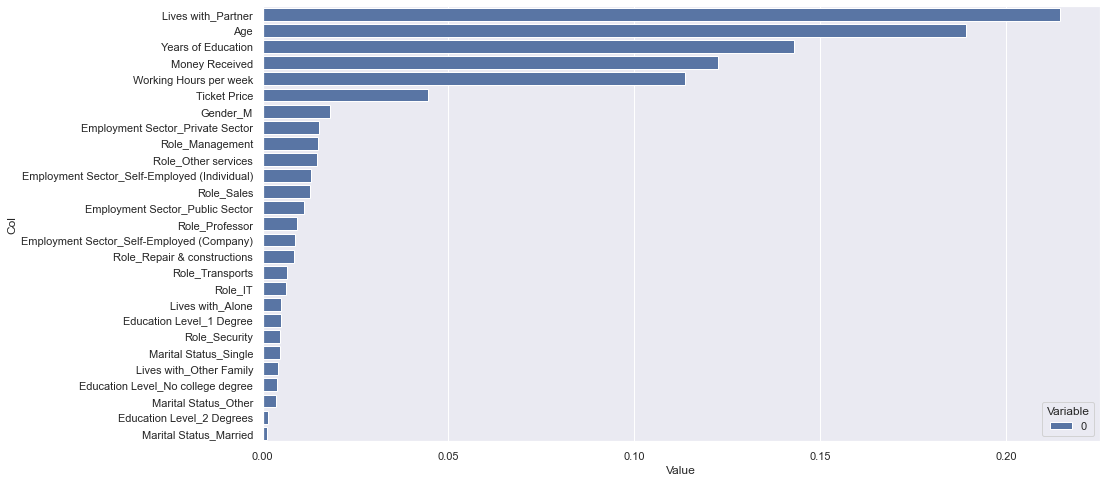

In [98]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [99]:
X_dt=X.drop(["Marital Status_Married","Lives with_Alone","Marital Status_Married","Role_Security","Lives with_Other Family","Education Level_1 Degree","Marital Status_Single","Education Level_2 Degrees","Role_Transports"],axis=1)

### Data Split after feature selection

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y, train_size=0.8, random_state=42,stratify=y,shuffle=True) 

In [101]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=6,min_samples_split=4,min_samples_leaf=10,random_state=70) 
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=10,
                       min_samples_split=4, random_state=70)

In [102]:
y_train_pred= dt.predict(X_train)
y_test_pred=dt.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     13671
           1       0.80      0.52      0.63      4249

    accuracy                           0.86     17920
   macro avg       0.83      0.74      0.77     17920
weighted avg       0.85      0.86      0.84     17920

[[13106   565]
 [ 2027  2222]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [103]:
dt_f1_test=micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.8553571428571428
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.8575892857142857


### Cross-Validation

In [104]:
cv_results = cross_validate(dt, X_train,y_train, cv=5, scoring=["f1_micro"])
dt_cross_f1=cv_results["test_f1_micro"].mean()
dt_cross_f1

0.8531808035714287

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, dt.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, dt.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### Grid Search Cv

In [105]:
criterion_range=["gini","entropy"] 
max_depth_range=[2,4,6,8]
min_samples_split_range=[4,6,8,10]
min_samples_leaf_range=[4,6,8,10]
random_state_range=[20,35,70]
param_grid=dict(random_state=random_state_range)
grid=GridSearchCV(estimator=dt,param_grid=param_grid, cv =5)

In [106]:
#grid.fit(X_train,y_train)
#grid.best_params_

### SGDClassifier NAO DEMOS EM AULA

### Feature Selection

Vamos usar as variavies usadas no random forest

In [107]:
X_gp=X.loc[:,feature_columns]

### Data Split after feature selection

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_gp, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    stratify=y)

In [109]:
sgd= SGDClassifier(penalty='elasticnet',alpha=0.001,l1_ratio=0.2,random_state=70,n_jobs=-1)
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.001, l1_ratio=0.2, n_jobs=-1, penalty='elasticnet',
              random_state=70)

In [110]:
y_train_pred= sgd.predict(X_train)
y_test_pred=sgd.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     13671
           1       0.66      0.50      0.57      4249

    accuracy                           0.82     17920
   macro avg       0.76      0.71      0.73     17920
weighted avg       0.81      0.82      0.81     17920

[[12555  1116]
 [ 2113  2136]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [111]:
sgd_f1_test=micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.8198102678571428
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.8238839285714286


### Cross-Validation

In [112]:
cv_results = cross_validate(sgd, X_train,y_train, cv=5, scoring=["f1_micro"])
sgd_cross_f1=cv_results["test_f1_micro"].mean()

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, sgd.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, sgd.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### Grid Search Cv

In [113]:
penalty_range=["l2","l1","elasticnet"] 
alpha_range=[0.0001,0.001,0.01]
l1_ratio_range=[0.15,0.20,0.25]
epsilon_range=[0.1,0.15,0.20]
random_state_range=[20,35,70]
param_grid=dict(random_state=random_state_range)
grid=GridSearchCV(estimator=sgd,param_grid=param_grid, cv =5)

In [114]:
#grid.fit(X_train,y_train)
#grid.best_params_

### ExtraTreesClassifier NAO DEMOS EM AULA

### Data Splitting

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

In [116]:
etc = ExtraTreesClassifier() 
etc.fit(X_train,y_train)

ExtraTreesClassifier()

In [117]:
best_scale(gb,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.849777
MinMax,0.873884
MaxAbs,0.873661
Robust,0.874777
No Scaler,0.873884


### Feature Selection

In [118]:
importances = etc.feature_importances_
indices = np.argsort(importances)

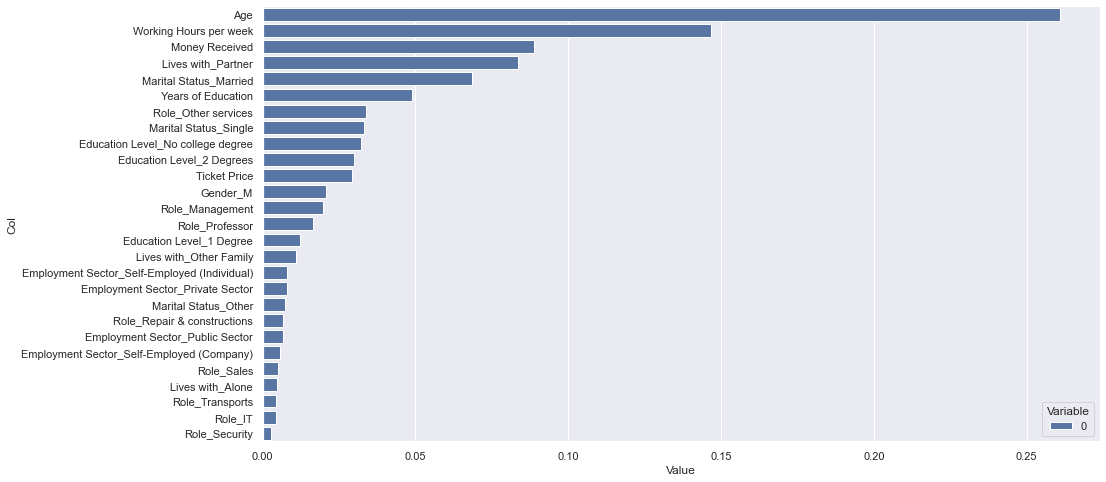

In [119]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [120]:
X_etc=X.drop(["Role_IT","Lives with_Alone","Role_Sales","Role_Security","Role_Transports","Employment Sector_Self-Employed (Company)","Role_Repair & constructions","Employment Sector_Self-Employed (Individual)","Marital Status_Other"],axis=1)

### Data Split after feature selection

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_etc, y, train_size=0.8, random_state=42,stratify=y,shuffle=True) 

In [122]:
etc = ExtraTreesClassifier(max_depth=10,min_samples_split=12,min_samples_leaf=4,max_features='log2',random_state=35,n_jobs=-1) 
etc.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                     min_samples_split=12, n_jobs=-1, random_state=35)

In [123]:
y_train_pred= etc.predict(X_train)
y_test_pred=etc.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     13671
           1       0.75      0.52      0.61      4249

    accuracy                           0.85     17920
   macro avg       0.81      0.73      0.76     17920
weighted avg       0.84      0.85      0.84     17920

[[12954   717]
 [ 2044  2205]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [126]:
etc_f1_test = micro_f1_score(y_train,y_train_pred,y_test,y_test_pred)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.8459263392857143
_____________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
0.8477678571428571


### Cross-Validation

In [128]:
cv_results = cross_validate(etc, X_train,y_train, cv=5, scoring=["f1_micro"])
etc_cross_f1=cv_results["test_f1_micro"].mean()

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, etc.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, etc.predict(X_test))
plt.plot(fpr_train, tpr_train,label="ROC Curve train")
plt.plot(fpr_test, tpr_test,label="ROC Curve test")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### Grid Search Cv

In [ ]:
criterion_range=["gini","entropy"] 
max_depth_range=[4,6,8,10]
min_samples_split_range=[6,8,10,12]
min_samples_leaf_range=[4,6,8,10]
max_features_range=["auto","sqrt","log2"]
random_state_range=[20,35,70]
param_grid=dict(random_state=random_state_range)
grid=GridSearchCV(estimator=etc,param_grid=param_grid, cv =5)

In [ ]:
#grid.fit(X_train,y_train)
#grid.best_params_

### Conclusion

In [130]:
data={"Cross Validation Train F1":[sgd_cross_f1,dt_cross_f1,ada_cross_f1,gb_cross_f1,rf_cross_f1,etc_cross_f1,mlp_cross_f1],
      "F1 Test" : [sgd_f1_test,dt_f1_test,ada_f1_test,gb_f1_test,rf_test_f1,etc_f1_test,mlp_f1_test]}

In [135]:
conclusion=pd.DataFrame(data=data,index=["SGD","DT","ADA","GB","RF","ETC","MLP"])
conclusion

,Cross Validation Train F1,F1 Test
SGD,0.804185,0.823884
DT,0.853181,0.857589
ADA,0.762891,0.762946
GB,0.867188,0.874777
RF,0.860993,0.865402
ETC,0.839007,0.847768
MLP,0.836607,0.838393


### Final Model

In [ ]:
X1=X[feature_columns]
y2=df.loc[:,"Income"]

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100,max_features=15,random_state=70,max_depth=6,min_samples_leaf=10) 
gb.fit(X1,y2)

### EXPORT

In [ ]:
test = pd.read_excel("../test.xlsx")
original=test.copy()
df.replace("?", np.nan, inplace=True)

test[["Gender","Name"]]=test["Name"].str.split(" ", n=1,expand=True)
test["Gender"].replace(["Mr."],"M",inplace=True)
test["Gender"].replace(["Miss","Mrs."],"F",inplace=True)
test[["Mouth","Year"]]=test['Birthday'].str.split(",",expand=True)
test["Year"]=test["Year"].astype(int)
test["Age"] = 2046 - test["Year"]
test.set_index("CITIZEN_ID",inplace=True)
test.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

categorical = test.select_dtypes(include="object").columns.to_list()
numerical = test.columns.drop(categorical)

test["Marital Status"].replace(["Married - Spouse in the Army" ],"Married",inplace=True)
test["Marital Status"].replace(["Married - Spouse Missing" ,"Widow","Divorced"],"Other",inplace=True)
test["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
test["Lives with"].replace(["Other relatives","Children"],"Other",inplace=True)
#tem demasiadas categorias
test.drop(["Base Area","Native Continent"],axis=1,inplace=True)
categorical.remove("Base Area")
categorical.remove("Native Continent")

test["Education Level"].replace(["High School - 2nd Cycle","High School - 1st Cycle","Middle School Complete","Primary School","Preschool","High School Complete","High School - 1st Cycle","High School - 2nd Cycle","Professional School","Middle School - 1st Cycle","Middle School - 2nd Cycle"],"No college degree",inplace=True)
test["Education Level"].replace(["High School + PostGraduation","Bachelors","Professional School + PostGraduation"],"1 Degree",inplace=True)
test["Education Level"].replace(["Bachelors + PostGraduation","Masters"],"2 Degrees",inplace=True)
test["Education Level"].replace(["Masters + PostGraduation","PhD"],"3 Degrees",inplace=True)
test["Employment Sector"].replace(["Private Sector - Services ","Private Sector - Others"],"Private Sector",inplace=True)
test["Employment Sector"].replace(["Public Sector - Others","Public Sector - Government"],"Public Sector",inplace=True)
test["Employment Sector"].replace(["Unemployed","Never Worked"],"Other",inplace=True)
test["Role"].replace(["Cleaners & Handlers","Machine Operators & Inspectors","Administratives","Agriculture and Fishing","Household Services"],"Other services",inplace=True)
#test["Working Hours per week/age"]=test["Working Hours per week"]/test["Age"]
#test["Years of Education/age"]=df["Years of Education"]/test["Age"]
#test["Working Hours per week/Years of Education"]=test["Working Hours per week"]/test["Years of Education"]*100

modes = test[categorical].mode().loc[0]
test.fillna(modes,inplace=True)

categorical=test.select_dtypes(include="object").columns.to_list()

df_ohc = test.copy()
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index,columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
test=df_ohc.copy()
test=test[feature_columns]
#test=RobustScaler().fit(test).transform(test)


results=gb.predict(test)
# final dataframe

dataframe=pd.DataFrame()

dataframe["CITIZEN_ID"]=original["CITIZEN_ID"]
dataframe["Income"]= results

dataframe.to_csv("MAA_202021_44.csv",index=False)